## Week6

In this part, we'll load a pre-trained network and play with it.

In [1]:
from __future__ import print_function
from sys import version_info

import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import theano
import theano.tensor as T
import lasagne

try:
    import cPickle as pickle
except ImportError:
    import pickle

%matplotlib inline

from scipy.misc import imread, imsave, imresize
from lasagne.utils import floatX

Using gpu device 0: Quadro M1000M (CNMeM is disabled, cuDNN 5105)
/home/ivan/.virtualenvs/math/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


# Model Zoo (4 pts)
Lasagne has a plethora of pre-training netrworks in the [model zoo](https://github.com/Lasagne/Recipes/tree/master/modelzoo)
* Even more models within the community (neighbor repos, PRs, etc.)


We'll start by picking VGG16 and deploying it in our notebook.

__Warning!__ VGG16 network requires around 3GB of memory to predict event for single-image batch. If you don't have that luxury, try [binder](http://mybinder.org/repo/yandexdataschool/practical_rl) or [azure notebooks](http://notebooks.azure.com/).


In [2]:
## !wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl -O weights.pkl

In [3]:
# copyright: see http://www.robots.ox.ac.uk/~vgg/research/very_deep/


from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import softmax


def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(
        net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(
        net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(
        net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(
        net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(
        net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(
        net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(
        net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(
        net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(
        net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(
        net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(
        net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(
        net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(
        net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(
        net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)
    return net

In [4]:
#classes' names are stored here
classes = pickle.load(open('classes.pkl', 'rb'))
#for example, 10th class is ostrich:
print(classes[9])

ostrich, Struthio camelus


You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 3, 224, 224). Without this transformation, our net won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [5]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
    img = np.stack([b, g, r], axis=2)
    img = img - MEAN_VALUES

    img = np.transpose(img, (2, 0, 1))[None]
    return floatX(img)

def deprocess(img):
    img = img.reshape(img.shape[1:]).transpose((1, 2, 0))
    for i in range(3):
        img[:,:, i] += MEAN_VALUES[i]
    return img[:, :, :: -1].astype(np.uint8)

img = (np.random.rand(IMAGE_W, IMAGE_W, 3) * 256).astype(np.uint8)

print(np.linalg.norm(deprocess(preprocess(img)) - img))

0.0


If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

### Deploy the network

In [6]:
net = build_model()

In [7]:
with open('weights.pkl', 'rb') as f:
    if version_info.major == 2:
        weights = pickle.load(f)
    elif version_info.major == 3:
        weights = pickle.load(f, encoding='latin1')
    
lasagne.layers.set_all_param_values(net['prob'], weights['param values'])

In [8]:
input_image = T.tensor4('input')
output = lasagne.layers.get_output(net['prob'], input_image, deterministic=True)
prob = theano.function([input_image], output) 

### Sanity check
Let's make sure our network actually works. 

To do so, we'll feed it with some example images.

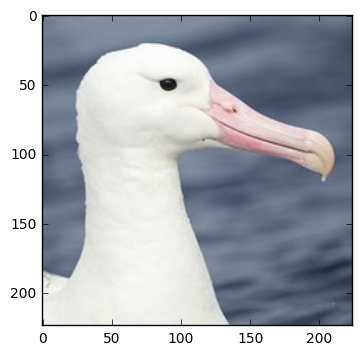

top-5 classes are:
0.996280	albatross
0.003715	goose
0.000001	drake
0.000001	white stork
0.000001	spoonbill


In [9]:
img = imread('sample_images/albatross.jpg')
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

##### Ouch!
Try running network 2-3 times. If output changes, then we've probably done something wrong.

Figure out, what's the problem with the network.

_hint_ there are two such 'problematic' layers in vgg16. They're all near the end.

You can make network deterministic by giving it such flag in the `lasagne.layers.get_output` function above.

#### Fun opportunity

ImageNet does not contain any human classes, so if you feed the network with some human photo, it will most likely hallucinate something which is closest to your image.

Try feeding the network with something peculiar: your avatar, Donald Trump, Victor Lempitsky or anyone.

# Grand-quest: Dogs Vs Cats (6 pts)
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [10]:
### !wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
### !unzip data.zip
#you may need to adjust paths in the next section, depending on your OS

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [11]:
such_img = T.tensor4('input')

res = lasagne.layers.get_output([net['prob'], 
                                 net['fc8'],
                                 net['fc7'],
                                 net['fc6'],
                                 net['pool5']], such_img, deterministic=True)


vgg = theano.function([such_img], res)

In [12]:
## #extract features from images
## ## from tqdm import tqdm
## from scipy.misc import imresize

## X = []
## Y = []

## #this may be a tedious process. If so, store the results in some pickle and re-use them.
## for fname in tqdm(os.listdir('train/')):
##     y = fname.startswith("cat")
##     img = imread("train/" + fname)
##     img = preprocess(imresize(img,(IMAGE_W,IMAGE_W)))
##     
##     Y.append(y)
##     X.append(vgg(img))

In [13]:
## cut 1000, 1000, 4096, 4096

In [14]:
## new_X = []
## for data in X:
##     new_X.append(np.concatenate([x.reshape(-1) for x in data[:4]]))

## new_X = np.array(new_X)

## np.savez("cat_vs_dogs_dataset.npz", X=new_X, Y=Y)

In [15]:
import numpy as np

data = np.load("cat_vs_dogs_dataset.npz")
X, Y = data['X'][:,1000:], data['Y']

In [16]:
from sklearn.cross_validation import train_test_split

X_train, X_tmp, y_train, y_tmp = train_test_split(X, Y, test_size=0.3, random_state=1488)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=228)

/home/ivan/.virtualenvs/math/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

# Main quest

* Get the score improved!

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.

The main requirement is that you implement the NN fine-tuning recipe:
### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k
### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout
### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output
### Train the newly added layers for some iterations
  * you can selectively train some weights by only sending them to your optimizer
      * `lasagne.updates.mysupermegaoptimizer(loss, only_those_weights_i_wanna_train)`
  * selecting all weights from the head but not below the neck:
      * `all_params = lasagne.layers.get_all_params(new_output_layer_or_layers,trainable=True)`
      * `old_params= lasagne.layers.get_all_params(neck_layers,trainable=True)`
      * `new_params = [w for w in all_params if w not in old_params]`
  * it's cruicial to monitor the network performance at this and following steps
### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * since updates are dictionaries, one can just compute union
      * `updates = {}`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * make sure they do not have overlapping keys. Otherwise, earlier one will be forgotten.
      * `assert len(updates) == len(old_updates) + len(new_updates)`
### PROFIT!!!
  * Evaluate the final score
  * Submit to kaggle
      * competition page https://www.kaggle.com/c/dogs-vs-cats
      * get test data https://www.kaggle.com/c/dogs-vs-cats/data
  
## Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 85%/90%/93%/95%/97% kaggle score (screen pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, n_jobs=4, verbose=10)
rf.fit(X_train, y_train)

building tree 1 of 200building tree 2 of 200

building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.2s


building tree 13 of 200


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.3s


building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    5.0s


building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    7.3s


building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   10.0s


building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.4s


building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200


[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   15.7s


building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200


[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   18.2s


building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200


[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   22.5s


building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200


[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   26.3s


building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200
building tree 109 of 200


[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   30.5s


building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200


[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   35.1s


building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200


[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   39.5s


building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   44.6s


building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200


[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   50.3s


building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   55.8s


building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   57.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=4, oob_score=False, random_state=None,
            verbose=10, warm_start=False)

In [18]:
from sklearn.metrics import accuracy_score

accuracy_score(y_valid, rf.predict(X_valid))

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Do

0.9821333333333333

![img](http://s4.pikabu.ru/post_img/2014/10/13/11/1413224845_1633266346.jpg)

## Ну давайте возьмём датасет с кагла и посмотрим, что будет на борде

In [19]:
#extract features from images
## from tqdm import tqdm
## from scipy.misc import imresize


## kaggle_X, kaggle_y = [], []
## for fname in tqdm(sorted(os.listdir('kaggle_test/test1/'))):
##     img = imread("kaggle_test/test1/" + fname)
##     img = preprocess(imresize(img,(IMAGE_W,IMAGE_W)))
##     
##     kaggle_X.append(np.concatenate([x.reshape(-1) for x in vgg(img)[:4]]))
##     kaggle_y.append(fname)

In [20]:
## np.savez("kaggle_X.npz", X=kaggle_X, Y=kaggle_y)

In [21]:
import numpy as np

_ = np.load("kaggle_X.npz")
kaggle_X, kaggle_Y = _["X"][:,1000:], _["Y"]

In [22]:
final_predictions = rf.predict(kaggle_X)

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Do

In [23]:
with open("subm.csv", 'w') as outfile:
    outfile.write("id,label\n")
    
    for (fn, p) in zip(kaggle_Y, final_predictions):
        label = 1 if p == False else 0
        outfile.write("{},{}\n".format(fn.split(".")[0], label))

In [24]:
!shuf subm.csv | head -n10

6946,0
6937,0
4061,0
12120,1
7492,1
7673,0
876,1
3711,0
1533,0
9007,0
shuf: write error: Broken pipe
shuf: write error


### К сожалению каггл не даёт сделать сабмишн, так что на этом всё